In [1]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [2]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

2023-08-31 06:14:05.252197: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 06:14:05.256301: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 06:14:05.321600: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 06:14:05.323093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 06:14:06.437407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### smiles_dict

In [3]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [4]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [5]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [6]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [7]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [8]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [9]:
seq = 'CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'

from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))

c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
c1ccc(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cc1
c1cc(COc2cc(-n3nc(OCC)oc3=O)ccc2)ccc1
c1(OCc2ccccc2)cc(-n2c(=O)oc(OCC)n2)ccc1
O(c1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1)CC
c1ccc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)cc1
c1(COc2cccc(-n3c(=O)oc(OCC)n3)c2)ccccc1
c1c(COc2cccc(-n3nc(OCC)oc3=O)c2)cccc1
c1ccc(OCc2ccccc2)cc1-n1c(=O)oc(OCC)n1
c1cc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccc1


In [10]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
O=c1n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
C(C)Oc1nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
n1(-c2cccc(OCc3ccccc3)c2)c(=O)oc(OCC)n1
c1c(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)cccc1
c1c(OCc2ccccc2)cccc1-n1c(=O)oc(OCC)n1
c1ccc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)cc1
c1(-n2c(=O)oc(OCC)n2)cccc(OCc2ccccc2)c1
c1ccccc1COc1cccc(-n2c(=O)oc(OCC)n2)c1
C(c1ccccc1)Oc1cccc(-n2c(=O)oc(OCC)n2)c1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [11]:
from datagen import DataGenerator

In [12]:
max_sequence_len

224

In [13]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [14]:
len(dgen) * dgen.batch_size

6160

In [15]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

In [16]:
X_b

array([[16,  7, 16, ...,  0,  0,  0],
       [31,  7, 28, ...,  0,  0,  0],
       [17, 16,  2, ...,  0,  0,  0],
       ...,
       [28,  7, 28, ...,  0,  0,  0],
       [16, 21, 16, ...,  0,  0,  0],
       [16,  7, 16, ...,  0,  0,  0]])

In [17]:
y_b.shape

(13,)

# Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(4925,)

In [21]:
X_train = X_train[:4500]
y_train = y_train[:4500]

In [22]:
len(X_train), len(y_train), len(X_test)

(4500, 4500, 1232)

In [23]:
X_train

array(['COc1cc(/C=C/c2ccc3ccccc3[n+]2C)ccc1N1CCOCC1.[I-]',
       'CCCCCCCNC(=O)Oc1ccc2c(c1)C1(C)CCN(CC)C2C1',
       'c1ccc2c(COc3nn(CCN4CCCC4)c4ccccc34)cccc2c1', ...,
       'Cl.Nc1c2c(nc3ccc(F)cc13)CCC2',
       'CCN(CC)CCCCCOc1ccc(C(=O)/C=C/c2ccccc2)cc1',
       'COc1ccccc1/C=C1\\CN(C(=O)C[C@H]2C[C@H]3CCCN3[C@]23C(=O)Nc2ccccc23)C/C(=C\\c2ccccc2OC)C1=O'],
      dtype=object)

In [24]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [25]:
dgen_train

In [26]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

# Network Model

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [28]:
import tensorflow as tf
from tensorflow.keras import layers as L

def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    
    # Customized embedding layer
    embedding = L.Embedding(input_dim=vocab_size, output_dim=embedding_size)(input_x)
    
    pooled_outputs = []
    for filter_size in filter_sizes:
        # Convolutional layer with L2 regularization and Leaky ReLU activation
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(embedding)
        
        # Max and average pooling layers
        max_p = L.GlobalMaxPooling1D()(conv)
        avg_p = L.GlobalAveragePooling1D()(conv)
        
        pooled_outputs.extend([max_p, avg_p])
        
    concatenated_pooling = L.Concatenate()(pooled_outputs)
    
    # Batch normalization
    normalized_layer = L.BatchNormalization()(concatenated_pooling)
    
    # Fully connected layers with dropout and different activations
    dense = L.Dense(256, activation='relu')(normalized_layer)
    dense = L.Dropout(0.5)(dense)
    dense = L.Dense(128, activation='tanh')(dense)
    dense = L.Dropout(0.2)(dense)
    
    # Output layer
    output_layer = L.Dense(1, activation='linear')(dense)
    
    model = tf.keras.models.Model(input_x, output_layer)
    return model


In [29]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (2, 3, 4)
NUM_FILTERS = 256
vocab_size = len(smiles_dict) + 1
embeddings_size = 64 # 2

In [30]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_x (InputLayer)        [(None, 224)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 224, 64)              2752      ['input_x[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 223, 256)             33024     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 222, 256)             49408     ['embedding[0][0]']           
                                                                                              

In [31]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [32]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])
history = model.fit(dgen_train, epochs=50, validation_data=dgen_test,callbacks=[mcp])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 30.8982 - R2: -10.4761INFO:tensorflow:Assets written to: models/best_model_1/assets


INFO:tensorflow:Assets written to: models/best_model_1/assets


36/36 [==============================] - 20s 424ms/step - loss: 30.8982 - R2: -10.4761 - val_loss: 34.0838 - val_R2: -11.6322
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 12.2421 - R2: -2.8238INFO:tensorflow:Assets written to: models/best_model_2/assets


INFO:tensorflow:Assets written to: models/best_model_2/assets


36/36 [==============================] - 9s 244ms/step - loss: 12.2421 - R2: -2.8238 - val_loss: 26.1362 - val_R2: -8.3486
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 6.4233 - R2: -0.4062INFO:tensorflow:Assets written to: models/best_model_3/assets


INFO:tensorflow:Assets written to: models/best_model_3/assets


36/36 [==============================] - 10s 291ms/step - loss: 6.4233 - R2: -0.4062 - val_loss: 22.4126 - val_R2: -6.9924
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 5.8240 - R2: -0.1502INFO:tensorflow:Assets written to: models/best_model_4/assets


INFO:tensorflow:Assets written to: models/best_model_4/assets


36/36 [==============================] - 14s 394ms/step - loss: 5.8240 - R2: -0.1502 - val_loss: 21.4595 - val_R2: -6.5381
Epoch 5/50
36/36 [==============================] - ETA: 0s - loss: 5.5270 - R2: -0.0447INFO:tensorflow:Assets written to: models/best_model_5/assets


INFO:tensorflow:Assets written to: models/best_model_5/assets


36/36 [==============================] - 11s 302ms/step - loss: 5.5270 - R2: -0.0447 - val_loss: 20.4134 - val_R2: -6.1059
Epoch 6/50
36/36 [==============================] - ETA: 0s - loss: 5.3851 - R2: 0.0122INFO:tensorflow:Assets written to: models/best_model_6/assets


INFO:tensorflow:Assets written to: models/best_model_6/assets


36/36 [==============================] - 9s 247ms/step - loss: 5.3851 - R2: 0.0122 - val_loss: 19.4898 - val_R2: -5.9765
Epoch 7/50
36/36 [==============================] - ETA: 0s - loss: 5.1988 - R2: 0.0622INFO:tensorflow:Assets written to: models/best_model_7/assets


INFO:tensorflow:Assets written to: models/best_model_7/assets


36/36 [==============================] - 13s 369ms/step - loss: 5.1988 - R2: 0.0622 - val_loss: 18.0028 - val_R2: -5.2442
Epoch 8/50
36/36 [==============================] - ETA: 0s - loss: 5.1571 - R2: 0.0736INFO:tensorflow:Assets written to: models/best_model_8/assets


INFO:tensorflow:Assets written to: models/best_model_8/assets


36/36 [==============================] - 13s 359ms/step - loss: 5.1571 - R2: 0.0736 - val_loss: 17.4820 - val_R2: -5.0955
Epoch 9/50
36/36 [==============================] - ETA: 0s - loss: 5.0515 - R2: 0.1174INFO:tensorflow:Assets written to: models/best_model_9/assets


INFO:tensorflow:Assets written to: models/best_model_9/assets


36/36 [==============================] - 14s 378ms/step - loss: 5.0515 - R2: 0.1174 - val_loss: 16.2926 - val_R2: -4.5150
Epoch 10/50
36/36 [==============================] - ETA: 0s - loss: 4.9590 - R2: 0.1375INFO:tensorflow:Assets written to: models/best_model_10/assets


INFO:tensorflow:Assets written to: models/best_model_10/assets


36/36 [==============================] - 14s 389ms/step - loss: 4.9590 - R2: 0.1375 - val_loss: 14.4925 - val_R2: -3.7458
Epoch 11/50
36/36 [==============================] - ETA: 0s - loss: 4.8523 - R2: 0.1710INFO:tensorflow:Assets written to: models/best_model_11/assets


INFO:tensorflow:Assets written to: models/best_model_11/assets


36/36 [==============================] - 11s 315ms/step - loss: 4.8523 - R2: 0.1710 - val_loss: 12.3602 - val_R2: -2.9582
Epoch 12/50
36/36 [==============================] - ETA: 0s - loss: 4.7745 - R2: 0.1916INFO:tensorflow:Assets written to: models/best_model_12/assets


INFO:tensorflow:Assets written to: models/best_model_12/assets


36/36 [==============================] - 9s 250ms/step - loss: 4.7745 - R2: 0.1916 - val_loss: 10.5794 - val_R2: -2.1943
Epoch 13/50
36/36 [==============================] - ETA: 0s - loss: 4.6726 - R2: 0.1925INFO:tensorflow:Assets written to: models/best_model_13/assets


INFO:tensorflow:Assets written to: models/best_model_13/assets


36/36 [==============================] - 11s 318ms/step - loss: 4.6726 - R2: 0.1925 - val_loss: 9.6609 - val_R2: -1.8136
Epoch 14/50
36/36 [==============================] - ETA: 0s - loss: 4.6178 - R2: 0.2309INFO:tensorflow:Assets written to: models/best_model_14/assets


INFO:tensorflow:Assets written to: models/best_model_14/assets


36/36 [==============================] - 11s 302ms/step - loss: 4.6178 - R2: 0.2309 - val_loss: 8.0597 - val_R2: -1.2727
Epoch 15/50
36/36 [==============================] - ETA: 0s - loss: 4.5635 - R2: 0.2477INFO:tensorflow:Assets written to: models/best_model_15/assets


INFO:tensorflow:Assets written to: models/best_model_15/assets


36/36 [==============================] - 10s 272ms/step - loss: 4.5635 - R2: 0.2477 - val_loss: 6.5501 - val_R2: -0.6062
Epoch 16/50
36/36 [==============================] - ETA: 0s - loss: 4.5028 - R2: 0.2375INFO:tensorflow:Assets written to: models/best_model_16/assets


INFO:tensorflow:Assets written to: models/best_model_16/assets


36/36 [==============================] - 11s 297ms/step - loss: 4.5028 - R2: 0.2375 - val_loss: 5.6516 - val_R2: -0.2126
Epoch 17/50
36/36 [==============================] - ETA: 0s - loss: 4.4727 - R2: 0.2453INFO:tensorflow:Assets written to: models/best_model_17/assets


INFO:tensorflow:Assets written to: models/best_model_17/assets


36/36 [==============================] - 13s 373ms/step - loss: 4.4727 - R2: 0.2453 - val_loss: 5.1725 - val_R2: -0.0302
Epoch 18/50
36/36 [==============================] - ETA: 0s - loss: 4.3762 - R2: 0.2678INFO:tensorflow:Assets written to: models/best_model_18/assets


INFO:tensorflow:Assets written to: models/best_model_18/assets


36/36 [==============================] - 13s 349ms/step - loss: 4.3762 - R2: 0.2678 - val_loss: 4.2376 - val_R2: 0.3418
Epoch 19/50
36/36 [==============================] - ETA: 0s - loss: 4.2480 - R2: 0.3183INFO:tensorflow:Assets written to: models/best_model_19/assets


INFO:tensorflow:Assets written to: models/best_model_19/assets


36/36 [==============================] - 10s 287ms/step - loss: 4.2480 - R2: 0.3183 - val_loss: 3.9847 - val_R2: 0.4295
Epoch 20/50
36/36 [==============================] - ETA: 0s - loss: 4.2484 - R2: 0.3075INFO:tensorflow:Assets written to: models/best_model_20/assets


INFO:tensorflow:Assets written to: models/best_model_20/assets


36/36 [==============================] - 11s 300ms/step - loss: 4.2484 - R2: 0.3075 - val_loss: 3.8842 - val_R2: 0.4436
Epoch 21/50
36/36 [==============================] - ETA: 0s - loss: 4.1818 - R2: 0.3254INFO:tensorflow:Assets written to: models/best_model_21/assets


INFO:tensorflow:Assets written to: models/best_model_21/assets


36/36 [==============================] - 14s 397ms/step - loss: 4.1818 - R2: 0.3254 - val_loss: 3.8303 - val_R2: 0.4562
Epoch 22/50
36/36 [==============================] - ETA: 0s - loss: 4.1822 - R2: 0.2961INFO:tensorflow:Assets written to: models/best_model_22/assets


INFO:tensorflow:Assets written to: models/best_model_22/assets


36/36 [==============================] - 13s 366ms/step - loss: 4.1822 - R2: 0.2961 - val_loss: 3.7560 - val_R2: 0.4764
Epoch 23/50
36/36 [==============================] - ETA: 0s - loss: 4.0803 - R2: 0.3347INFO:tensorflow:Assets written to: models/best_model_23/assets


INFO:tensorflow:Assets written to: models/best_model_23/assets


36/36 [==============================] - 11s 306ms/step - loss: 4.0803 - R2: 0.3347 - val_loss: 3.7418 - val_R2: 0.4672
Epoch 24/50
36/36 [==============================] - ETA: 0s - loss: 4.0186 - R2: 0.3393INFO:tensorflow:Assets written to: models/best_model_24/assets


INFO:tensorflow:Assets written to: models/best_model_24/assets


36/36 [==============================] - 9s 255ms/step - loss: 4.0186 - R2: 0.3393 - val_loss: 3.7058 - val_R2: 0.4720
Epoch 25/50
36/36 [==============================] - ETA: 0s - loss: 4.0165 - R2: 0.3402INFO:tensorflow:Assets written to: models/best_model_25/assets


INFO:tensorflow:Assets written to: models/best_model_25/assets


36/36 [==============================] - 12s 340ms/step - loss: 4.0165 - R2: 0.3402 - val_loss: 3.6881 - val_R2: 0.4513
Epoch 26/50
36/36 [==============================] - ETA: 0s - loss: 3.9164 - R2: 0.3637INFO:tensorflow:Assets written to: models/best_model_26/assets


INFO:tensorflow:Assets written to: models/best_model_26/assets


36/36 [==============================] - 13s 361ms/step - loss: 3.9164 - R2: 0.3637 - val_loss: 3.6322 - val_R2: 0.4829
Epoch 27/50
36/36 [==============================] - ETA: 0s - loss: 3.8423 - R2: 0.3877INFO:tensorflow:Assets written to: models/best_model_27/assets


INFO:tensorflow:Assets written to: models/best_model_27/assets


36/36 [==============================] - 8s 233ms/step - loss: 3.8423 - R2: 0.3877 - val_loss: 3.6214 - val_R2: 0.4667
Epoch 28/50
36/36 [==============================] - ETA: 0s - loss: 3.8571 - R2: 0.3696INFO:tensorflow:Assets written to: models/best_model_28/assets


INFO:tensorflow:Assets written to: models/best_model_28/assets


36/36 [==============================] - 10s 287ms/step - loss: 3.8571 - R2: 0.3696 - val_loss: 3.6056 - val_R2: 0.4765
Epoch 29/50
36/36 [==============================] - ETA: 0s - loss: 3.7636 - R2: 0.3859INFO:tensorflow:Assets written to: models/best_model_29/assets


INFO:tensorflow:Assets written to: models/best_model_29/assets


36/36 [==============================] - 13s 356ms/step - loss: 3.7636 - R2: 0.3859 - val_loss: 3.4974 - val_R2: 0.5009
Epoch 30/50
36/36 [==============================] - 7s 189ms/step - loss: 3.7623 - R2: 0.3818 - val_loss: 3.5800 - val_R2: 0.4528
Epoch 31/50
36/36 [==============================] - ETA: 0s - loss: 3.7123 - R2: 0.3829INFO:tensorflow:Assets written to: models/best_model_31/assets


INFO:tensorflow:Assets written to: models/best_model_31/assets


36/36 [==============================] - 10s 278ms/step - loss: 3.7123 - R2: 0.3829 - val_loss: 3.3910 - val_R2: 0.5144
Epoch 32/50
36/36 [==============================] - ETA: 0s - loss: 3.6595 - R2: 0.3931INFO:tensorflow:Assets written to: models/best_model_32/assets


INFO:tensorflow:Assets written to: models/best_model_32/assets


36/36 [==============================] - 14s 384ms/step - loss: 3.6595 - R2: 0.3931 - val_loss: 3.3722 - val_R2: 0.5149
Epoch 33/50
36/36 [==============================] - 8s 226ms/step - loss: 3.6070 - R2: 0.4071 - val_loss: 3.4345 - val_R2: 0.4758
Epoch 34/50
36/36 [==============================] - ETA: 0s - loss: 3.5644 - R2: 0.4246INFO:tensorflow:Assets written to: models/best_model_34/assets


INFO:tensorflow:Assets written to: models/best_model_34/assets


36/36 [==============================] - 10s 278ms/step - loss: 3.5644 - R2: 0.4246 - val_loss: 3.3167 - val_R2: 0.5201
Epoch 35/50
36/36 [==============================] - 8s 216ms/step - loss: 3.5390 - R2: 0.4209 - val_loss: 3.4584 - val_R2: 0.4349
Epoch 36/50
36/36 [==============================] - 10s 283ms/step - loss: 3.4833 - R2: 0.4287 - val_loss: 3.5690 - val_R2: 0.3762
Epoch 37/50
36/36 [==============================] - ETA: 0s - loss: 3.4673 - R2: 0.4327INFO:tensorflow:Assets written to: models/best_model_37/assets


INFO:tensorflow:Assets written to: models/best_model_37/assets


36/36 [==============================] - 14s 396ms/step - loss: 3.4673 - R2: 0.4327 - val_loss: 3.2302 - val_R2: 0.5176
Epoch 38/50
36/36 [==============================] - 10s 279ms/step - loss: 3.4217 - R2: 0.4332 - val_loss: 3.2680 - val_R2: 0.4992
Epoch 39/50
36/36 [==============================] - ETA: 0s - loss: 3.3522 - R2: 0.4539INFO:tensorflow:Assets written to: models/best_model_39/assets


INFO:tensorflow:Assets written to: models/best_model_39/assets


36/36 [==============================] - 13s 359ms/step - loss: 3.3522 - R2: 0.4539 - val_loss: 3.1293 - val_R2: 0.5335
Epoch 40/50
36/36 [==============================] - 7s 181ms/step - loss: 3.2828 - R2: 0.4727 - val_loss: 3.1996 - val_R2: 0.5080
Epoch 41/50
36/36 [==============================] - 10s 265ms/step - loss: 3.2893 - R2: 0.4582 - val_loss: 3.2829 - val_R2: 0.4674
Epoch 42/50
36/36 [==============================] - 10s 284ms/step - loss: 3.2835 - R2: 0.4569 - val_loss: 3.1756 - val_R2: 0.5090
Epoch 43/50
36/36 [==============================] - ETA: 0s - loss: 3.2064 - R2: 0.4701INFO:tensorflow:Assets written to: models/best_model_43/assets


INFO:tensorflow:Assets written to: models/best_model_43/assets


36/36 [==============================] - 13s 367ms/step - loss: 3.2064 - R2: 0.4701 - val_loss: 3.0173 - val_R2: 0.5520
Epoch 44/50
36/36 [==============================] - 9s 238ms/step - loss: 3.2024 - R2: 0.4606 - val_loss: 3.0830 - val_R2: 0.5167
Epoch 45/50
36/36 [==============================] - 7s 185ms/step - loss: 3.1396 - R2: 0.4831 - val_loss: 3.2132 - val_R2: 0.4431
Epoch 46/50
36/36 [==============================] - ETA: 0s - loss: 3.1368 - R2: 0.4742INFO:tensorflow:Assets written to: models/best_model_46/assets


INFO:tensorflow:Assets written to: models/best_model_46/assets


36/36 [==============================] - 10s 274ms/step - loss: 3.1368 - R2: 0.4742 - val_loss: 2.9692 - val_R2: 0.5422
Epoch 47/50
36/36 [==============================] - ETA: 0s - loss: 3.0814 - R2: 0.4915INFO:tensorflow:Assets written to: models/best_model_47/assets


INFO:tensorflow:Assets written to: models/best_model_47/assets


36/36 [==============================] - 13s 370ms/step - loss: 3.0814 - R2: 0.4915 - val_loss: 2.9173 - val_R2: 0.5510
Epoch 48/50
36/36 [==============================] - 10s 273ms/step - loss: 3.0608 - R2: 0.4859 - val_loss: 2.9663 - val_R2: 0.5246
Epoch 49/50
36/36 [==============================] - 10s 261ms/step - loss: 3.0491 - R2: 0.4843 - val_loss: 2.9443 - val_R2: 0.5173
Epoch 50/50
36/36 [==============================] - ETA: 0s - loss: 2.9777 - R2: 0.5093INFO:tensorflow:Assets written to: models/best_model_50/assets


INFO:tensorflow:Assets written to: models/best_model_50/assets


36/36 [==============================] - 13s 352ms/step - loss: 2.9777 - R2: 0.5093 - val_loss: 2.8481 - val_R2: 0.5594


In [33]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [34]:
X_test_eval.shape, y_test.shape

((1232, 224), (1232,))

In [35]:
y_pred = model.predict(X_test_eval)

39/39 [==============================] - 1s 20ms/step


# Score

In [36]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [37]:
r2

0.5672260880277783

In [38]:
filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model.save(filename)

/home/nando/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
# model.summary()

# Load model (solo si se grabo el modelo)

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [42]:
y_pred = model_loaded.predict(X_test_eval)

39/39 [==============================] - 1s 15ms/step


In [43]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.5672260880277783

# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

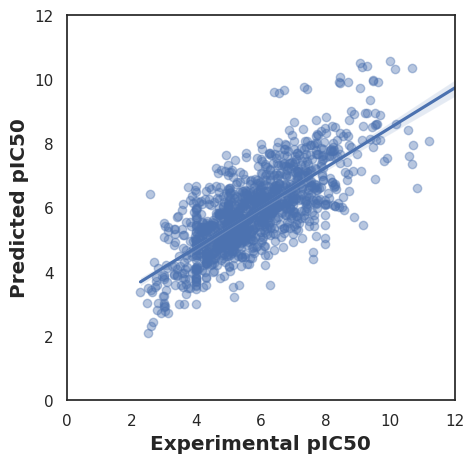

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show